# Israeli Elections

### Imports

In [2]:
import pandas as pd
import numpy as np
import random
import itertools
random.seed(0)
np.random.seed(0)
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.cluster import KMeans, MeanShift
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
from scipy.spatial.distance import cdist
# from jupyterthemes import jtplot # Addon for styling notebook. Comment this line out if needed (also the jtplot.style() in the next cell)

### Formatting jupyter cells

In [18]:
%matplotlib inline
# Forcing jupyter to display in full-width
display(HTML("<style>.container { width:100% !important; }</style>"))

# other display options
pd.set_option('display.max_columns', None)
# jtplot.style()

# Forcing side-by-side printing of output, when needed
CSS = """
div.cell:nth-child(12) .output {
    flex-direction: row;
}
div.cell:nth-child(14) .output {
    flex-direction: row;
}
div.cell:nth-child(33) .output {
    flex-direction: row;
}
div.cell:nth-child(39) .output {
    flex-direction: row;
}
div.cell:nth-child(40) .output {
    flex-direction: row;
}
div.cell:nth-child(43) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

### Load & clean elections' data

In [4]:
election21 = pd.read_csv("expb21.csv", encoding = "cp1255")
election22 = pd.read_csv("expb22.csv", encoding = "cp1255")
election23 = pd.read_csv("expb23.csv", encoding = "cp1255")

heb_to_eng = {"סמל ועדה": "cmtNum", "ברזל": "ballotId", "שם ישוב": "area", "סמל ישוב": "areaId", 
              "קלפי": "ballot", "ריכוז": "density", "שופט": "judge", "בזב": "eligible",
             "מצביעים": "voters", "פסולים": "invalid", "כשרים": "valid", "מספר קלפי": "ballot"}
for i in heb_to_eng: # renaming relevant columns
    election21 = election21.rename(columns={i: heb_to_eng.get(i)})
    election22 = election22.rename(columns={i: heb_to_eng.get(i)})
    election23 = election23.rename(columns={i: heb_to_eng.get(i)})
    
# election21 has a typo in column "דעם" - should be "ודעם"
election21 = election21.rename(columns={"דעם": "ודעם"})
# Dropping all 0-only columns.
election21 = election21.drop(np.array(election21.columns)[np.array(list((election21 == 0).all()))].tolist(), axis=1)
election22 = election22.drop(np.array(election22.columns)[np.array(list((election22 == 0).all()))].tolist(), axis=1)
election23 = election23.drop(np.array(election23.columns)[np.array(list((election23 == 0).all()))].tolist(), axis=1)
# We noticed that "מעטפות חיצוניות" had 0 eligible voters, which makes no sense, so we decided to change it to the amount of people that actually voted instead. (missing data)
for election in [election21, election22, election23]:
    election.loc[election['area'] == "מעטפות חיצוניות", 'eligible'] = election.loc[election.area == "מעטפות חיצוניות"].voters
# We noticed that "מעטפות חיצוניות" had different areaIDs in election21 than election22 and election23.
election21.loc[election21['area'] == "מעטפות חיצוניות", 'areaId'] = 9999


parties21 = list(election21.columns[7:]) # list of all parties
parties22 = list(election22.columns[11:])
parties23 = list(election23.columns[11:])

election21 = election21.groupby(['areaId', 'area'])[["eligible", "voters", "invalid", "valid"]+parties21].sum().reset_index()
election22 = election22.groupby(['areaId', 'area'])[["eligible", "voters", "invalid", "valid"]+parties22].sum().reset_index()
election23 = election23.groupby(['areaId', 'area'])[["eligible", "voters", "invalid", "valid"]+parties23].sum().reset_index()

totalVotes21 = dict.fromkeys(parties21 , 0) # votes for all parties
totalVotes22 = dict.fromkeys(parties22 , 0)
totalVotes23 = dict.fromkeys(parties23 , 0)
for party in parties21:
    totalVotes21[party] = election21[[party]].sum()[0]
for party in parties22:
    totalVotes22[party] = election22[[party]].sum()[0]
for party in parties23:
    totalVotes23[party] = election23[[party]].sum()[0]

## Question 2:

### Election23: Top 5 cities with the most valid votes (not including "מעטפות חיצוניות")

In [10]:
election23.loc[election23.area != "מעטפות חיצוניות", ["area", "valid"]].sort_values("valid", ascending=False).iloc[:5].style.hide_index()

area,valid
תל אביב יפו,267115
ירושלים,261589
חיפה,144625
ראשון לציון,137894
פתח תקווה,131489


### Top 5 places with the highest valid votes percentage for "מחל", and total votes less than 2k

In [11]:
print("Election21:")
display(election21.assign(Percent = 100 * election21['מחל'] / election21['valid']).sort_values('Percent', ascending=False).loc[(election21["voters"] < 2000), ["area", "Percent", "מחל", "valid"]].iloc[:5].style.hide_index())
print("Election22:")
display(election22.assign(Percent = 100 * election22['מחל'] / election22['valid']).sort_values('Percent', ascending=False).loc[(election22["voters"] < 2000), ["area", "Percent", "מחל", "valid"]].iloc[:5].style.hide_index())
print("Election23:")
display(election23.assign(Percent = 100 * election23['מחל'] / election23['valid']).sort_values('Percent', ascending=False).loc[(election23["voters"] < 2000), ["area", "Percent", "מחל", "valid"]].iloc[:5].style.hide_index())

Election21:


area,Percent,מחל,valid
גדיש,81.4433,158,194
שדי תרומות,77.7344,199,256
נועם,76.7442,165,215
גבעולים,71.1297,170,239
"דוב""ב",69.4444,175,252


Election22:


area,Percent,מחל,valid
שדי תרומות,82.9167,199,240
גדיש,76.5957,144,188
רחוב,73.3906,171,233
אליפלט,70.3593,235,334
"דוב""ב",69.8795,174,249


Election23:


area,Percent,מחל,valid
שדי תרומות,87.2659,233,267
גדיש,80,168,210
איבים,80,28,35
רחוב,78.8618,194,246
דובב,78.8,197,250


### Election23: Top 5 places with the highest valid votes percentage for "פה", and total votes less than 2k

In [12]:
print("Election21:")
display(election21.assign(Percent = 100 * election21['פה'] / election21['valid']).sort_values('Percent', ascending=False).loc[(election21["voters"] < 2000), ["area", "Percent", "פה", "valid"]].iloc[:5].style.hide_index())
print("Election22:")
display(election22.assign(Percent = 100 * election22['פה'] / election22['valid']).sort_values('Percent', ascending=False).loc[(election22["voters"] < 2000), ["area", "Percent", "פה", "valid"]].iloc[:5].style.hide_index())
print("Election23:")
display(election23.assign(Percent = 100 * election23['פה'] / election23['valid']).sort_values('Percent', ascending=False).loc[(election23["voters"] < 2000), ["area", "Percent", "פה", "valid"]].iloc[:5].style.hide_index())

Election21:


area,Percent,פה,valid
פארן,72,198,275
אלמגור,69.697,161,231
גבעת שפירא,69.6429,117,168
היוגב,69.5842,318,457
עין יהב,69.3467,276,398


Election22:


area,Percent,פה,valid
גבעת שפירא,69.8795,116,166
כפר כמא,69.5187,780,1122
מחנה יוכבד,69.0141,49,71
אלמגור,68.8034,161,234
עין יהב,68.5,274,400


Election23:


area,Percent,פה,valid
עין יהב,77.9793,301,386
אלמגור,77.1689,169,219
היוגב,76.5517,333,435
פארן,75.2896,195,259
עין ורד,75.1479,635,845


### Parties' votes by election

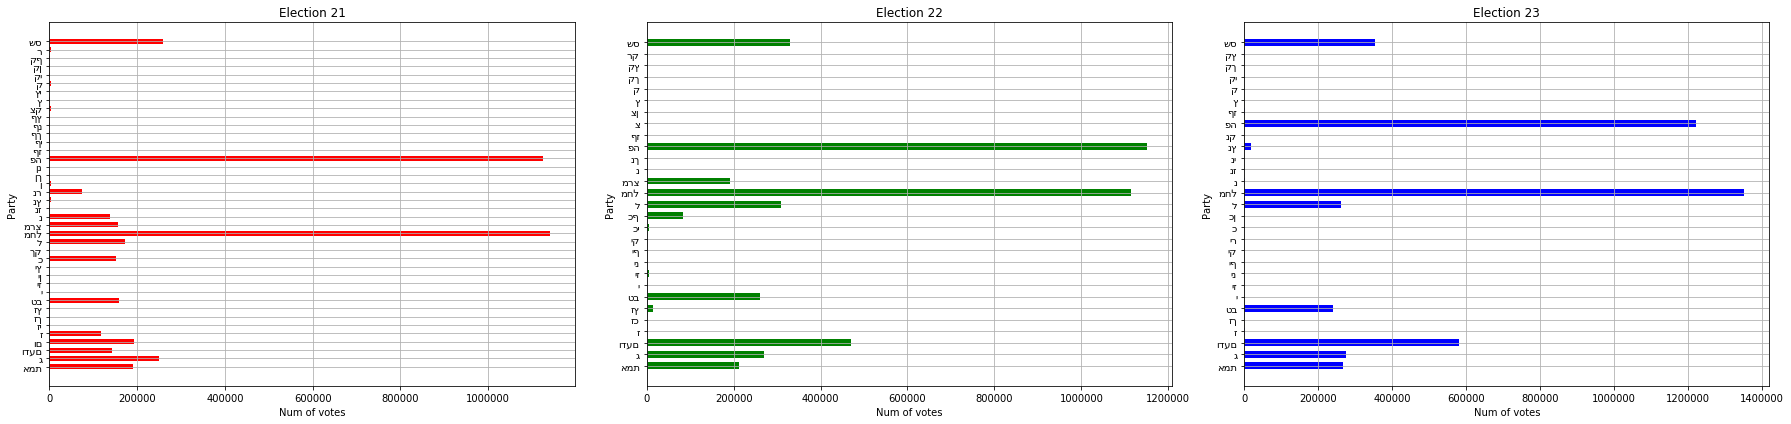

'Election 21'

אמת,ג,ודעם,ום,ז,זי,זך,זץ,טב,י,יז,ין,יץ,כ,ךק,ל,מחל,מרצ,נ,נז,נץ,נר,ן,ןך,ןנ,פה,ףז,ףי,ףך,ףנ,ףץ,צק,ץ,ץי,ק,קי,קן,קף,ר,שס
190870,249049,143666,193442,118031,1168,216,2417,159468,1438,353,265,428,152756,562,173004,1140370,156473,138598,1316,3394,74701,4618,404,385,1125881,819,733,518,401,624,3843,556,368,3281,701,603,1140,4135,258275


'Election 22'

אמת,ג,ודעם,ז,זכ,זץ,טב,י,יז,ינ,יף,יק,כי,כף,ל,מחל,מרצ,נ,נך,פה,ףז,צ,צן,ץ,ק,קך,קץ,רק,שס
212782,268775,470211,1193,736,14805,260655,434,4358,610,542,497,5946,83609,310154,1113617,192495,1033,1545,1151214,1236,3053,725,592,1473,928,994,2395,330199


'Election 23'

אמת,ג,ודעם,ז,זך,טב,י,יז,ינ,יף,יק,יר,כ,כן,ל,מחל,נ,נז,ני,נץ,נק,פה,ףז,ץ,ק,קי,קך,קץ,שס
267480,274437,581507,3781,210,240689,308,342,677,222,389,271,516,812,263365,1352449,2773,667,350,19402,622,1220381,1473,612,980,442,677,1375,352853


In [7]:
x21, x22, x23 = list(parties21), list(parties22), list(parties23)
x21_pos, x22_pos, x23_pos = np.arange(len(x21)), np.arange(len(x22)), np.arange(len(x23))
y21, y22, y23 = [], [], []
for party in parties21:
    y21.append(totalVotes21[party])
for party in parties22:
    y22.append(totalVotes22[party])
for party in parties23:
    y23.append(totalVotes23[party])

width = 0.6
plt.subplot(1, 3, 1)
plt.barh(x21_pos, y21, width, color="r")
plt.title("Election 21")
plt.ylabel("Party")
plt.xlabel("Num of votes")
plt.yticks(x21_pos, x21)
plt.grid()

plt.subplot(1, 3, 2)
plt.barh(x22_pos, y22, width, color="g")
plt.title("Election 22")
plt.ylabel("Party")
plt.xlabel("Num of votes")
plt.yticks(x22_pos, x22)
plt.grid()

plt.subplot(1, 3, 3)
plt.barh(x23_pos, y23, width, color="b")
plt.title("Election 23")
plt.ylabel("Party")
plt.xlabel("Num of votes")
plt.yticks(x23_pos, x23)
plt.grid()

plt.tight_layout()
plt.rcParams["figure.figsize"] = (25,6)
plt.show()

allVotes21 = []
for party in parties21:
    allVotes21.append(election21[party].sum())
sumDf21 = pd.DataFrame([allVotes21], columns=parties21)
display("Election 21",sumDf21.style.hide_index())
allVotes22 = []
for party in parties22:
    allVotes22.append(election22[party].sum())
sumDf22 = pd.DataFrame([allVotes22], columns=parties22)
display("Election 22",sumDf22.style.hide_index())
allVotes23 = []
for party in parties23:
    allVotes23.append(election23[party].sum())
sumDf23 = pd.DataFrame([allVotes23], columns=parties23)
display("Election 23",sumDf23.style.hide_index())

### Pie chart of total valid, invalid and abstained votes

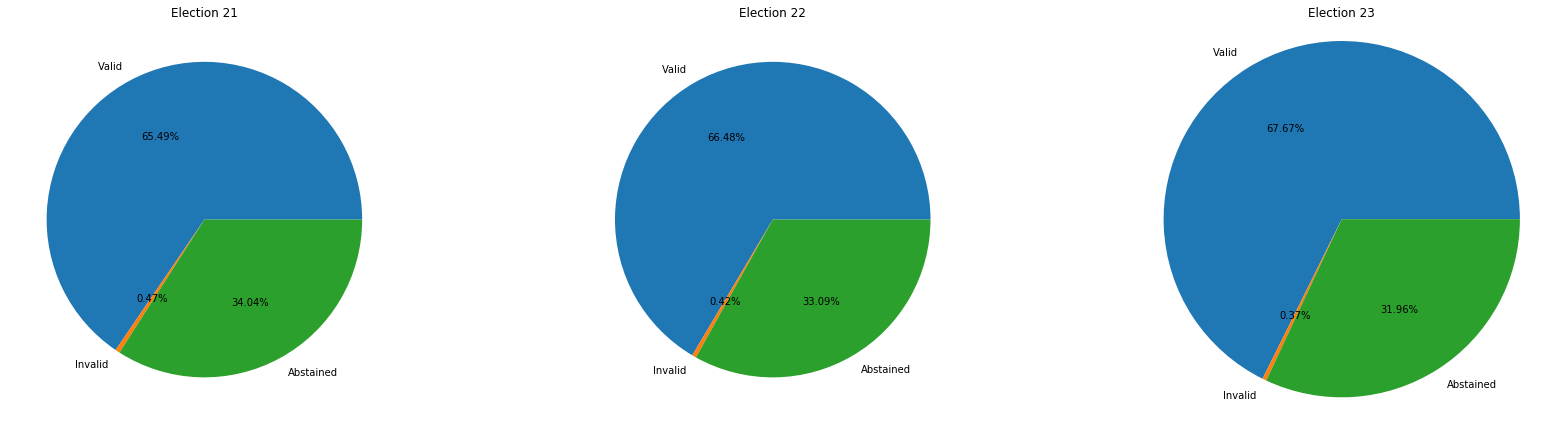

In [32]:
pieLabels = 'Valid', 'Invalid', 'Abstained'

plt.subplot(1, 3, 1, title="Election 21")
pieValues = [election21["valid"].sum(), election21["invalid"].sum(), election21["eligible"].sum() - election21["voters"].sum()]
plt.pie(pieValues, labels=pieLabels, autopct='%1.2f%%')

plt.subplot(1, 3, 2, title="Election 22")
pieValues = [election22["valid"].sum(), election22["invalid"].sum(), election22["eligible"].sum() - election22["voters"].sum()]
plt.pie(pieValues, labels=pieLabels, autopct='%1.2f%%')

plt.subplot(1, 3, 3, title="Election 23")
pieValues = [election23["valid"].sum(), election23["invalid"].sum(), election23["eligible"].sum() - election23["voters"].sum()]
plt.pie(pieValues, labels=pieLabels, autopct='%1.2f%%')

plt.axis('scaled')
plt.tight_layout()
plt.show()

### All recurring parties:

In [8]:
partiesIntersection = list(set(sumDf21.columns).intersection(set(sumDf22.columns)).intersection(set(sumDf23.columns)))
display("Election 21",sumDf21[partiesIntersection].style.hide_index())
display("Election 22",sumDf22[partiesIntersection].style.hide_index())
display("Election 23",sumDf23[partiesIntersection].style.hide_index())

'Election 21'

ףז,מחל,י,ק,נ,אמת,ז,ץ,ג,ל,שס,ודעם,פה,יז,טב
819,1140370,1438,3281,138598,190870,118031,556,249049,173004,258275,143666,1125881,353,159468


'Election 22'

ףז,מחל,י,ק,נ,אמת,ז,ץ,ג,ל,שס,ודעם,פה,יז,טב
1236,1113617,434,1473,1033,212782,1193,592,268775,310154,330199,470211,1151214,4358,260655


'Election 23'

ףז,מחל,י,ק,נ,אמת,ז,ץ,ג,ל,שס,ודעם,פה,יז,טב
1473,1352449,308,980,2773,267480,3781,612,274437,263365,352853,581507,1220381,342,240689


In [9]:
# creating dataframes with the same columns
def allElectionsIntersection():
    election21norm = election21[(["areaId", "area", "eligible", "voters", "valid", "invalid"]+partiesIntersection)].copy()
    election22norm = election22[(["areaId", "area", "eligible", "voters", "valid", "invalid"]+partiesIntersection)].copy()
    election23norm = election23[(["areaId", "area", "eligible", "voters", "valid", "invalid"]+partiesIntersection)].copy()
    return election21norm, election22norm, election23norm
election21norm, election22norm, election23norm = allElectionsIntersection()
# normalizing results
for results in [election21norm, election22norm, election23norm]:
    results.loc[:,partiesIntersection] = results.loc[:,partiesIntersection].div(results.valid, axis=0)
    results.loc[:,"valid":"invalid"] = results.loc[:,"valid":"invalid"].div(results.voters, axis=0)
    results.loc[:,"voters"] = results.loc[:,"voters"].div(results.eligible, axis=0)

display(election21norm.head(), election22norm.head(), election23norm.head())

,areaId,area,eligible,voters,valid,invalid,ףז,מחל,י,ק,נ,אמת,ז,ץ,ג,ל,שס,ודעם,פה,יז,טב
0,7,שחר,516,0.718992,1.000000,0.000000,0.0,0.380054,0.0,0.000000,0.061995,0.045822,0.021563,0.0,0.005391,0.013477,0.088949,0.0,0.266846,0.0,0.008086
1,10,תירוש,333,0.711712,0.991561,0.008439,0.0,0.527660,0.0,0.000000,0.017021,0.017021,0.004255,0.0,0.012766,0.000000,0.310638,0.0,0.021277,0.0,0.042553
2,11,"ניר ח""ן",403,0.717122,0.996540,0.003460,0.0,0.291667,0.0,0.000000,0.059028,0.072917,0.038194,0.0,0.000000,0.006944,0.006944,0.0,0.385417,0.0,0.013889
3,13,חצבה,502,0.802789,1.000000,0.000000,0.0,0.064516,0.0,0.007444,0.052109,0.109181,0.039702,0.0,0.004963,0.002481,0.004963,0.0,0.620347,0.0,0.012407
4,15,נועם,302,0.718543,0.990783,0.009217,0.0,0.767442,0.0,0.000000,0.004651,0.004651,0.009302,0.0,0.018605,0.000000,0.116279,0.0,0.023256,0.0,0.023256


,areaId,area,eligible,voters,valid,invalid,ףז,מחל,י,ק,נ,אמת,ז,ץ,ג,ל,שס,ודעם,פה,יז,טב
0,7,שחר,517,0.729207,1.000000,0.000000,0.0,0.339523,0.0,0.000000,0.000000,0.082228,0.000000,0.0,0.021220,0.029178,0.103448,0.000000,0.259947,0.000000,0.074271
1,10,תירוש,332,0.737952,1.000000,0.000000,0.0,0.379592,0.0,0.000000,0.000000,0.004082,0.004082,0.0,0.016327,0.000000,0.424490,0.000000,0.024490,0.000000,0.044898
2,11,"ניר ח""ן",406,0.706897,1.000000,0.000000,0.0,0.198606,0.0,0.000000,0.003484,0.111498,0.000000,0.0,0.003484,0.034843,0.013937,0.003484,0.327526,0.000000,0.045296
3,13,חצבה,502,0.743028,1.000000,0.000000,0.0,0.067024,0.0,0.005362,0.000000,0.064343,0.000000,0.0,0.005362,0.048257,0.002681,0.000000,0.579088,0.002681,0.045576
4,15,נועם,308,0.740260,0.995614,0.004386,0.0,0.696035,0.0,0.000000,0.000000,0.004405,0.000000,0.0,0.017621,0.004405,0.158590,0.000000,0.057269,0.000000,0.035242


,areaId,area,eligible,voters,valid,invalid,ףז,מחל,י,ק,נ,אמת,ז,ץ,ג,ל,שס,ודעם,פה,יז,טב
0,7,שחר,521,0.742802,1.000000,0.000000,0.00000,0.452196,0.0,0.0,0.002584,0.054264,0.00000,0.0,0.015504,0.028424,0.124031,0.00000,0.279070,0.0,0.038760
1,10,תירוש,331,0.761329,1.000000,0.000000,0.00000,0.539683,0.0,0.0,0.000000,0.007937,0.00000,0.0,0.011905,0.003968,0.373016,0.00000,0.019841,0.0,0.039683
2,11,ניר חן,404,0.670792,1.000000,0.000000,0.00369,0.309963,0.0,0.0,0.000000,0.107011,0.00369,0.0,0.000000,0.066421,0.025830,0.00369,0.420664,0.0,0.055351
3,13,חצבה,519,0.763006,0.987374,0.012626,0.00000,0.076726,0.0,0.0,0.002558,0.115090,0.00000,0.0,0.002558,0.030691,0.002558,0.00000,0.700767,0.0,0.063939
4,15,נועם,313,0.750799,0.995745,0.004255,0.00000,0.747863,0.0,0.0,0.000000,0.004274,0.00000,0.0,0.008547,0.000000,0.179487,0.00000,0.029915,0.0,0.021368


## Question 3:

### Helper functions:

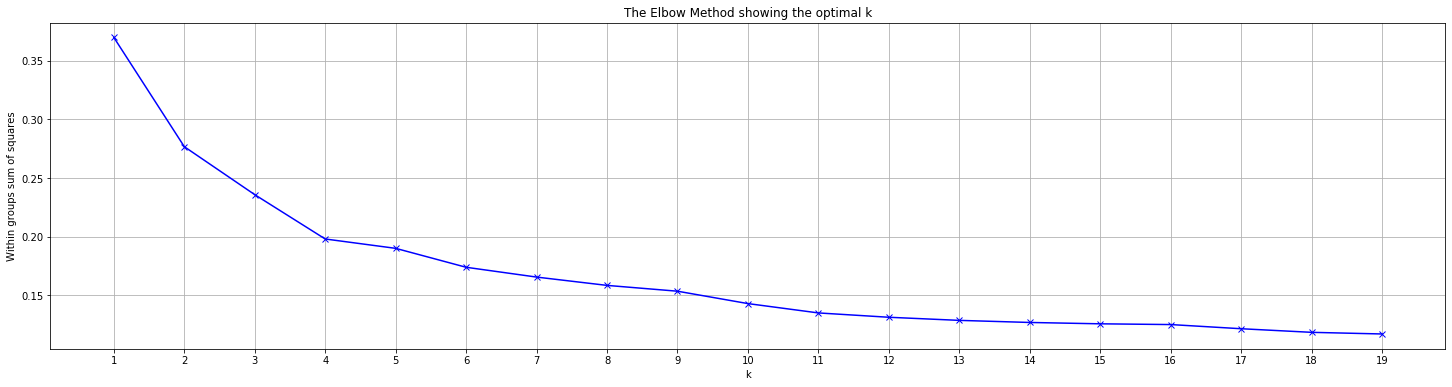

In [10]:
def elbow_met(df): # taken from the practice slides
    # k means determine k
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within groups sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.grid()
    plt.xticks(K)
    plt.show()

def real_and_predictions(election, model, trainDf):
    predictions = []
    real_results = []
    centroids = model.cluster_centers_
    df = pd.DataFrame(centroids, columns =trainDf.columns) 
    clusters = {}
    for index, row in df.iterrows():
        for p in partiesIntersection:
            if row.get(p) == max(row[3:]):
                clusters[index] = p
    for index, row in election.iterrows():
        # creating predictions array
        prediction = model.predict(election.loc[election["areaId"]==row.areaId].drop(["area", "areaId", "eligible"], axis=1))[0]
        predictions.append(prediction)
        # creating real_results array
        for p in partiesIntersection:    
            if row.get(p) == max(row[6:]):
                if p in clusters.values():
                    real_results.append(list(clusters.keys())[list(clusters.values()).index(p)])
                    break
                else:
                    real_results.append(-1)
                    break
    return real_results, predictions, clusters

elbow_met(election21norm.drop(["area", "areaId", "eligible"], axis=1))

### K-Means Clustering:

From the elbow method's graph above, we can infer that the optimal K is 4.<br>
Let us assume that with a voting populace under 2000 people, an area is considered a Kibbutz.<br>
The following script will help us predict (using K-means and MeanShift) which party the average kibbutz voted for:

In [12]:
trainDf = election21norm.drop(["area", "areaId", "eligible"], axis=1)
kmeans = KMeans(n_clusters=4, random_state=0).fit(trainDf)

election = election22norm.loc[election22norm["eligible"] < 2000] # Assuming the voting populace of an average Kibbutz is under 2k
real_results, predictions, clusters = real_and_predictions(election, kmeans, trainDf)
print("KMeans accuracy:\t",accuracy_score(real_results, predictions))
print("# of rows in test:\t",len(real_results))
print("Party voted on avg:\t",clusters[list(pd.Series(predictions).mode())[0]])

KMeans accuracy:	 0.9547738693467337
# of rows in test:	 995
Party voted on avg:	 פה


### MeanShift Clustering:

In [13]:
trainDf = election21norm.drop(["area", "areaId", "eligible"], axis=1)
ms = MeanShift().fit(trainDf)

election = election22norm.loc[election22norm["eligible"] < 2000] # Assuming the voting populace of an average Kibbutz is under 2k
real_results, predictions, clusters = real_and_predictions(election, ms, trainDf)
print("MeanShift accuracy:\t",accuracy_score(real_results, predictions))
print("# of rows in test:\t",len(real_results))
print("Party voted on avg:\t",clusters[list(pd.Series(predictions).mode())[0]])

MeanShift accuracy:	 0.7658291457286432
# of rows in test:	 995
Party voted on avg:	 פה


While the final answer of both clustering models remain the same, the accuracy differs greatly. We shall prefer to use the K-means model, in our test dataset (Election 23):

In [14]:
testDf = pd.concat([election21norm.drop(["area", "areaId", "eligible"], axis=1), election22norm.drop(["area", "areaId", "eligible"], axis=1)], ignore_index=True)
kmeans = KMeans(n_clusters=4, random_state=0).fit(testDf)

election = election23norm.loc[election23norm["eligible"] < 2000] # Assuming the voting populace of an average Kibbutz is under 2k
real_results, predictions, clusters = real_and_predictions(election, kmeans, testDf)
print("KMeans accuracy:\t",accuracy_score(real_results, predictions))
print("# of rows in test:\t",len(real_results))
print("Party voted on avg:\t",clusters[list(pd.Series(predictions).mode())[0]])

KMeans accuracy:	 0.9475277497477296
# of rows in test:	 991
Party voted on avg:	 פה


## Question 4:

In [11]:
election21norm, election22norm, election23norm = allElectionsIntersection()
for results in [election21norm, election22norm, election23norm]: # normalizing only the parties
    results.loc[:,partiesIntersection] = results.loc[:,partiesIntersection].div(results.valid, axis=0)
# combining election 21 & 22 to be used as the training data
train_df = pd.concat([election21norm.drop(["valid", "invalid"], axis=1), election22norm.drop(["valid", "invalid"], axis=1)], ignore_index=True)
train_labels = np.array(pd.concat([election21norm, election22norm], ignore_index=True).valid)
parameters = {'n_estimators': range(5, 10, 1),
                      'min_samples_split': range(2, 5, 1),
                      'max_depth': range(10, 15, 1),
                      'max_features': ['sqrt', 15, 16]}
# fitting a random forest regressor with the best estimators found in the grid-search, given parameters above
clf = GridSearchCV(RandomForestRegressor(criterion='mse', n_jobs=-1, random_state=0), param_grid=parameters,
                   cv=5,iid=False,n_jobs=-1).fit(train_df.drop(["area", "areaId"], axis=1), train_labels).best_estimator_
test_labels = np.array(election23norm.valid)
test_df = election23norm.drop(["valid", "invalid"], axis=1)
predictions = clf.predict(election23norm.drop(["area", "areaId", "valid", "invalid"], axis=1))
print("MSE:\n" + str(mean_squared_error(test_labels, predictions)))
# predicting valid votes for requested areas:
data = []
for area in ["חיפה", "איילת השחר", "אילת", "סח'נין", "קצרין"]:
    row = []
    if area != "סח'נין":
        row.append(area)
        row.append(int(election23norm.loc[election23norm["area"]==area].valid))
        row.append(int(clf.predict(election23norm.drop(["area", "areaId", "valid", "invalid"], axis=1).loc[election23norm["area"]==area])))
    else: # typo in area's name for election23, doing it separately
        row.append("סחנין")
        row.append(int(election23norm.loc[election23norm["area"]=="סחנין"].valid))
        row.append(int(clf.predict(election23norm.drop(["area", "areaId", "valid", "invalid"], axis=1).loc[election23norm["area"]=="סחנין"])))
    data.append(row)
results = pd.DataFrame(data, columns=["Area", "Actual-Valid", "Predicted-Valid"])
display(results.style.hide_index())
display(clf)

MSE:
4899400.525251451


Area,Actual-Valid,Predicted-Valid
חיפה,144625,149802
איילת השחר,585,585
אילת,22636,22317
סחנין,17085,16986
קצרין,3498,3486


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features=15, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

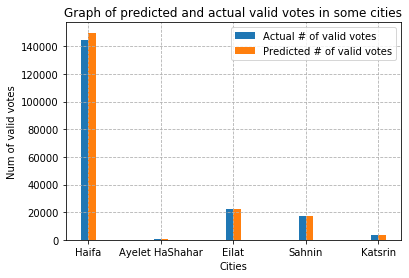

'Feature importance:'

array([3.81485330e-01, 6.03443669e-01, 2.96237947e-04, 1.29138636e-02,
       2.01605586e-04, 1.00558879e-05, 1.04694956e-04, 2.12746540e-04,
       1.94733213e-04, 2.54552547e-04, 7.60196770e-05, 1.22187731e-04,
       4.31964892e-05, 7.73307821e-05, 4.09674179e-04, 6.45558965e-07,
       1.53455651e-04])

Index(['areaId', 'area', 'eligible', 'voters', 'ףז', 'מחל', 'י', 'ק', 'נ',
       'אמת', 'ז', 'ץ', 'ג', 'ל', 'שס', 'ודעם', 'פה', 'יז', 'טב'],
      dtype='object')

In [19]:
# Bar graph visualisation for the tables above
cities = ["Haifa", "Ayelet HaShahar", "Eilat", "Sahnin", "Katsrin"]
actual = list(results["Actual-Valid"])
predicted = list(results["Predicted-Valid"])
fig, ax = plt.subplots()
width = 0.1
ax.bar(np.arange(1,len(cities)+1) - width/2, actual, width, label="Actual # of valid votes")
ax.bar(np.arange(1,len(cities)+1) + width/2, predicted, width, label="Predicted # of valid votes")
plt.xticks(range(1,6),cities)
plt.xlabel("Cities")
plt.ylabel("Num of valid votes")
plt.title("Graph of predicted and actual valid votes in some cities")
plt.legend(loc=1)
plt.grid(which='both', linestyle='--')
plt.show()

# feature importance for the model
display("Feature importance:",clf.feature_importances_)
display(test_df.columns)

## Question 5:

### Helper function:

In [11]:
def buildTablesForQ4(e23, clf, areas, party):
    data = []
    for area in areas:
        row = []
        if area != "סח'נין" and area != "דאלית אל-כרמל":
            row.append(area)
            if party == "מחל":
                row.append(int(e23.loc[e23["area"]==area].מחל))
                row.append(int(clf.predict(e23.drop(["area", "areaId", "מחל"], axis=1).loc[e23["area"]==area])))
            elif party == "ודעם":
                row.append(int(e23.loc[e23["area"]==area].ודעם))
                row.append(int(clf.predict(e23.drop(["area", "areaId", "ודעם"], axis=1).loc[e23["area"]==area])))
            else:
                row.append(int(e23.loc[e23["area"]==area].פה))
                row.append(int(clf.predict(e23.drop(["area", "areaId", "פה"], axis=1).loc[e23["area"]==area])))
        elif area == "סח'נין" or area == "דאלית אל-כרמל": # typo in area's name for election23, doing it separately
            if area == "סח'נין":
                row.append("סחנין")
                if party == "מחל":
                    row.append(int(e23.loc[e23["area"]=="סחנין"].מחל))
                    row.append(int(clf.predict(e23.drop(["area", "areaId", "מחל"], axis=1).loc[e23["area"]=="סחנין"])))
                elif party == "ודעם":
                    row.append(int(e23.loc[e23["area"]=="סחנין"].ודעם))
                    row.append(int(clf.predict(e23.drop(["area", "areaId", "ודעם"], axis=1).loc[e23["area"]=="סחנין"])))
                else:
                    row.append(int(e23.loc[e23["area"]=="סחנין"].פה))
                    row.append(int(clf.predict(e23.drop(["area", "areaId", "פה"], axis=1).loc[e23["area"]=="סחנין"])))
            else:
                row.append("דאלית אלכרמל")
                if party == "מחל":
                    row.append(int(e23.loc[e23["area"]=="דאלית אלכרמל"].מחל))
                    row.append(int(clf.predict(e23.drop(["area", "areaId", "מחל"], axis=1).loc[e23["area"]=="דאלית אלכרמל"])))
                elif party == "ודעם":
                    row.append(int(e23.loc[e23["area"]=="דאלית אלכרמל"].ודעם))
                    row.append(int(clf.predict(e23.drop(["area", "areaId", "ודעם"], axis=1).loc[e23["area"]=="דאלית אלכרמל"])))
                else:
                    row.append(int(e23.loc[e23["area"]=="דאלית אלכרמל"].פה))
                    row.append(int(clf.predict(e23.drop(["area", "areaId", "פה"], axis=1).loc[e23["area"]=="דאלית אלכרמל"])))
        data.append(row)
    results = pd.DataFrame(data, columns=["Area", "Actual-{0}".format(party), "Predicted-{0}".format(party)])
    display(results.style.hide_index())
    return results

## AdaBoost Regression:

In [31]:
e21, e22, e23 = allElectionsIntersection()
# combining election 21 & 22 to be used as the training data
areas = ["ירושלים", "בני ברק", "סח'נין", "כרמיאל", "דאלית אל-כרמל"]
parameters = {'n_estimators': [50, 80, 100, 200, 250, 300],
              'learning_rate': [0.001, 0.0001],
              'loss': ['linear', 'square']}
for party in ["מחל", "ודעם", "פה"]:
    if party == "פה":
        train_df = pd.concat([e21.drop(["פה"], axis=1), e22.drop(["פה"], axis=1)], ignore_index=True)
        train_labels = np.array(pd.concat([e21, e22], ignore_index=True).פה)
        
        clf = GridSearchCV(AdaBoostRegressor(random_state=0), param_grid=parameters,
                           cv=5,iid=False,n_jobs=-1).fit(train_df.drop(["area", "areaId"], axis=1), train_labels).best_estimator_
        results1 = buildTablesForQ4(e23, clf, areas, "פה")
        print(clf)
    elif party == "ודעם":
        train_df = pd.concat([e21.drop(["ודעם"], axis=1), e22.drop(["ודעם"], axis=1)], ignore_index=True)
        train_labels = np.array(pd.concat([e21, e22], ignore_index=True).ודעם)

        clf = GridSearchCV(AdaBoostRegressor(random_state=0), param_grid=parameters,
                           cv=5,iid=False,n_jobs=-1).fit(train_df.drop(["area", "areaId"], axis=1), train_labels).best_estimator_
        results2 = buildTablesForQ4(e23, clf, areas, "ודעם")
        print(clf)
    else:
        train_df = pd.concat([e21.drop(["מחל"], axis=1), e22.drop(["מחל"], axis=1)], ignore_index=True)
        train_labels = np.array(pd.concat([e21, e22], ignore_index=True).מחל)

        clf = GridSearchCV(AdaBoostRegressor(random_state=0), param_grid=parameters,
                           cv=5,iid=False,n_jobs=-1).fit(train_df.drop(["area", "areaId"], axis=1), train_labels).best_estimator_
        results3 = buildTablesForQ4(e23, clf, areas, "מחל")
        print(clf)

Area,Actual-מחל,Predicted-מחל
ירושלים,72601,59990
בני ברק,4951,24615
סחנין,39,1664
כרמיאל,8879,9501
דאלית אלכרמל,407,130


AdaBoostRegressor(base_estimator=None, learning_rate=0.001, loss='linear',
                  n_estimators=300, random_state=0)


Area,Actual-ודעם,Predicted-ודעם
ירושלים,5321,318
בני ברק,22,265
סחנין,16610,8157
כרמיאל,468,245
דאלית אלכרמל,650,368


AdaBoostRegressor(base_estimator=None, learning_rate=0.0001, loss='linear',
                  n_estimators=50, random_state=0)


Area,Actual-פה,Predicted-פה
ירושלים,32800,68702
בני ברק,1133,213
סחנין,120,207
כרמיאל,6627,5188
דאלית אלכרמל,5200,2885


AdaBoostRegressor(base_estimator=None, learning_rate=0.001, loss='square',
                  n_estimators=300, random_state=0)


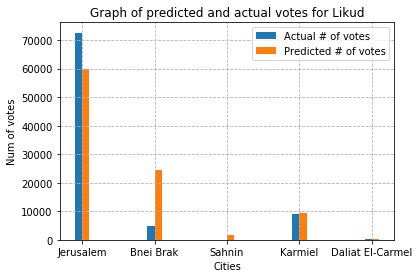

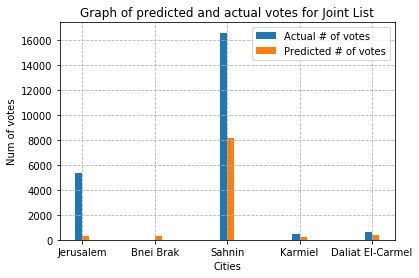

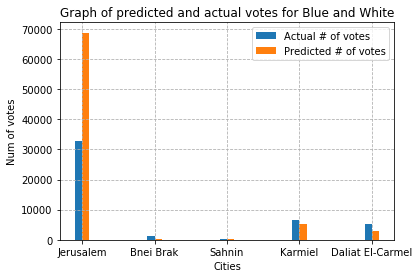

In [18]:
# Bar graph visualisation for the tables above
cities = ["Jerusalem", "Bnei Brak", "Sahnin", "Karmiel", "Daliat El-Carmel"]

actual3 = list(results3["Actual-מחל"])
predicted3 = list(results3["Predicted-מחל"])
fig, ax = plt.subplots()
width = 0.1
ax.bar(np.arange(1,len(cities)+1) - width/2, actual3, width, label="Actual # of votes")
ax.bar(np.arange(1,len(cities)+1) + width/2, predicted3, width, label="Predicted # of votes")
plt.xticks(range(1,6),cities)
plt.xlabel("Cities")
plt.ylabel("Num of votes")
plt.title("Graph of predicted and actual votes for Likud")
plt.legend(loc=1)
plt.grid(which='both', linestyle='--')
plt.show()

actual2 = list(results2["Actual-ודעם"])
predicted2 = list(results2["Predicted-ודעם"])
fig, ax = plt.subplots()
width = 0.1
ax.bar(np.arange(1,len(cities)+1) - width/2, actual2, width, label="Actual # of votes")
ax.bar(np.arange(1,len(cities)+1) + width/2, predicted2, width, label="Predicted # of votes")
plt.xticks(range(1,6),cities)
plt.xlabel("Cities")
plt.ylabel("Num of votes")
plt.title("Graph of predicted and actual votes for Joint List")
plt.legend(loc=1)
plt.grid(which='both', linestyle='--')
plt.show()

actual1 = list(results1["Actual-פה"])
predicted1 = list(results1["Predicted-פה"])
fig, ax = plt.subplots()
width = 0.1
ax.bar(np.arange(1,len(cities)+1) - width/2, actual1, width, label="Actual # of votes")
ax.bar(np.arange(1,len(cities)+1) + width/2, predicted1, width, label="Predicted # of votes")
plt.xticks(range(1,6),cities)
plt.xlabel("Cities")
plt.ylabel("Num of votes")
plt.title("Graph of predicted and actual votes for Blue and White")
plt.legend(loc=1)
plt.grid(which='both', linestyle='--')
plt.show()

In [33]:
# feature importance for the model
display("Feature importance:",train_df.columns,clf.feature_importances_)

'Feature importance:'

Index(['areaId', 'area', 'eligible', 'voters', 'valid', 'invalid', 'ל', 'שס',
       'נ', 'ודעם', 'אמת', 'ז', 'ץ', 'י', 'מחל', 'ק', 'יז', 'טב', 'ג', 'ףז'],
      dtype='object')

array([1.74342358e-02, 3.45944126e-02, 5.80580954e-02, 1.78106199e-03,
       2.26405180e-03, 1.30601053e-03, 3.25716247e-04, 3.97064113e-03,
       7.81329181e-01, 1.68466430e-03, 4.15022641e-02, 1.03529344e-02,
       7.48126239e-03, 1.32773922e-02, 6.36497256e-03, 1.22047216e-03,
       1.07075039e-03, 1.59818807e-02])

## Question 6:

In [34]:
# We used the total invalid votes per area, instead of the percentage, because only the amount of invalid votes actually affects election results. A high percentage
# of invalid votes doesn't necessarily mean it is significant, since the area it represents might also have a very low population.
e21, e22, e23 = allElectionsIntersection()
for results in [e21, e22, e23]: # normalizing only the parties
    results.loc[:,partiesIntersection] = results.loc[:,partiesIntersection].div(results.valid, axis=0)

train_df = pd.concat([e21.drop(["valid", "invalid"], axis=1), e21.drop(["valid", "invalid"], axis=1)], ignore_index=True)
train_labels = np.array(pd.concat([e21, e22], ignore_index=True).invalid)
parameters = {'n_estimators': [10, 50, 200],
              'learning_rate': [0.01, 0.001],
              'loss': ['linear']}
# fitting a random forest regressor with the best estimators found in the grid-search, given parameters above
clf = GridSearchCV(AdaBoostRegressor(random_state=0), param_grid=parameters,
                           cv=5,iid=False,n_jobs=-1).fit(train_df.drop(["area", "areaId"], axis=1), train_labels).best_estimator_

# predicting valid votes for requested areas:
data = []
for area in e23['area'].to_numpy():
    row = []
    row.append(area)
    row.append(int(clf.predict(e23.drop(["area", "areaId", "valid", "invalid"], axis=1).loc[e23["area"]==area])))
    data.append(row)
results = pd.DataFrame(data, columns=["area", "invalid"])
pred = results.loc[e23.area != "מעטפות חיצוניות", ["area", "invalid"]].sort_values("invalid", ascending=False)
display("Predicted top invalid votes",results.loc[e23.area != "מעטפות חיצוניות", ["area", "invalid"]].sort_values("invalid", ascending=False).head(14).style.hide_index(), clf)

true = e23.loc[e23.area != "מעטפות חיצוניות", ["area", "invalid"]].sort_values("invalid", ascending=False)
display("Actual top invalid votes:",e23.loc[e23.area != "מעטפות חיצוניות", ["area", "invalid"]].sort_values("invalid", ascending=False).head(14).style.hide_index())

'Predicted top invalid votes'

area,invalid
ירושלים,1980
תל אביב יפו,1122
בני ברק,970
חיפה,934
אשדוד,931
נתניה,908
פתח תקווה,903
חולון,854
אשקלון,781
ראשון לציון,775


AdaBoostRegressor(base_estimator=None, learning_rate=0.001, loss='linear',
                  n_estimators=200, random_state=0)

'Actual top invalid votes:'

area,invalid
ירושלים,1625
תל אביב יפו,1001
בני ברק,929
חיפה,863
באר שבע,785
אשדוד,694
פתח תקווה,646
נתניה,636
ראשון לציון,596
חולון,518


#### Confusion Matrix of number of towns needing a representative:

Confusion matrix, without normalization
[[1200    3]
 [   0   10]]


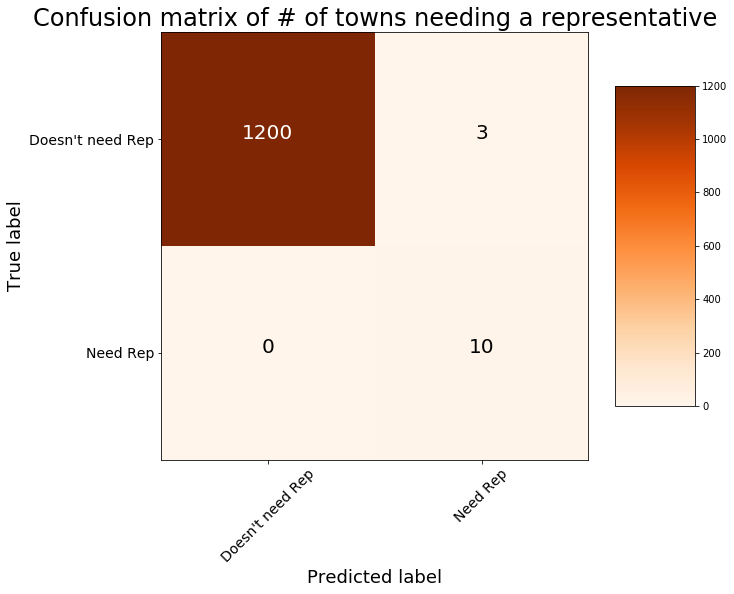

In [85]:
# Taken from tirgul
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix of # of towns needing a representative',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
#     plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# We chose 500 as the threshold for the invalid votes a town can have before we send a representative.
a = np.array(pred['invalid'].values.tolist())
pred['invalid'] = np.where(a < 500, 0, a).tolist()
a = np.array(pred['invalid'].values.tolist())
pred['invalid'] = np.where(a > 499, 1, a).tolist()
a = np.array(true['invalid'].values.tolist())
true['invalid'] = np.where(a < 500, 0, a).tolist()
a = np.array(true['invalid'].values.tolist())
true['invalid'] = np.where(a > 499, 1, a).tolist()

cm = confusion_matrix(list(true["invalid"]), list(pred["invalid"]))
plot_confusion_matrix(cm, classes = ["Doesn't need Rep", 'Need Rep'])

In [35]:
# feature importance for the model
display("Feature importance:",train_df.columns,clf.feature_importances_)

'Feature importance:'

Index(['areaId', 'area', 'eligible', 'voters', 'ל', 'שס', 'נ', 'ודעם', 'אמת',
       'ז', 'ץ', 'י', 'מחל', 'ק', 'יז', 'פה', 'טב', 'ג', 'ףז'],
      dtype='object')

array([0.69278036, 0.21018915, 0.01166007, 0.00285244, 0.00344656,
       0.00778606, 0.00321095, 0.00730812, 0.00617539, 0.00916538,
       0.00354049, 0.0030218 , 0.00220007, 0.00360373, 0.01863323,
       0.00910998, 0.00531622])